In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
import sympy as smp
from matplotlib import animation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import PillowWriter
import math 
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import scipy.constants as cs
from PIL import Image
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=100)

In [3]:
mu_B = sp.constants.physical_constants["Bohr magneton"][0]

# Magnetische Induktion $B$

In [4]:
I = [1,2,3,5,7,9,11,13,15,17]
I_err = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
B = [0.1,0.17,0.29,0.49,0.68,0.87,1.01,1.20,1.32,1.46]
B_err = [0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05]

In [5]:
def slope_fit(x,a):
    return a*x

popt1, pcov1 = curve_fit(slope_fit,I,B, p0=(1))
popt1

array([0.09011305])

In [6]:
pcov1

array([[1.75717304e-06]])

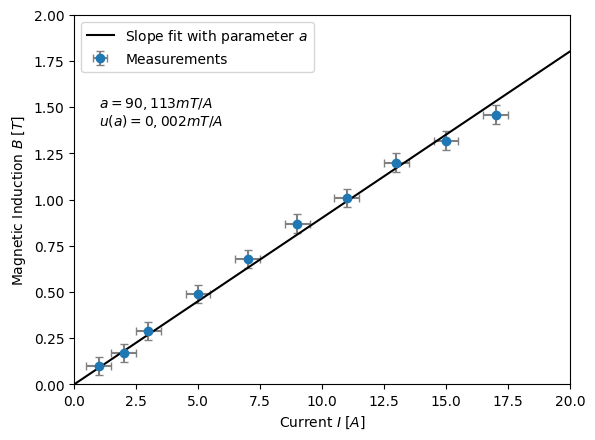

In [7]:
I_plot = np.linspace(0,20,1000)

plt.errorbar(I, B, xerr=I_err, yerr = B_err, ecolor='grey', fmt="o", capsize = 3,label="Measurements")
plt.plot(I_plot,I_plot*popt1[0],c='black',label=r'Slope fit with parameter $a$')
plt.xlabel(r'Current $I$ $[A]$')
plt.ylabel(r'Magnetic Induction $B$ $[T]$')
plt.legend(loc="upper left")
plt.text(1,1.5,r'$a = 90,113 mT/A$')
plt.text(1,1.4,r'$u(a) = 0,002 mT/A$')
plt.xlim(0,20)
plt.ylim(0,2)
#plt.savefig('Induction.png')
plt.show()

# Piezo-Korrektur und FSR

In [8]:
L = (6.72-5.94+1.4)*10**(-3)
FSR = cs.c/(2*L)
FSR

68759738073.39452

In [9]:
L

0.002179999999999999

In [10]:
def gauss(x,a,b,c):
    return a*np.exp(-((x-b)/c)**2)

def fit_peaks(x,a,b,c,d,e,f,g,h,i,j):
    return a*np.exp(-((x-b)/c)**2)+d*np.exp(-((x-e)/f)**2)+g*np.exp(-((x-h)/i)**2)+j

def lin_fit(x,a,b):
    return a*x+b

In [11]:
peaks = pd.read_table('../Messdaten/Peaks21/FPI_scan_data.dat').values

In [12]:
integer = peaks[:,0]
intensity = peaks[:,1]
ref_int = peaks[:,2]

In [13]:
popt2, pcov2 = curve_fit(fit_peaks,integer,intensity, p0=(80000,5000,800,80000,10000,800,80000,15000,800,200))
popt2

array([71682.75714641,  4907.69872242,   565.90869831, 74594.92807109,
       10103.61215706,   515.5024094 , 74349.44200869, 14971.12738483,
         498.63064729,  4557.56320684])

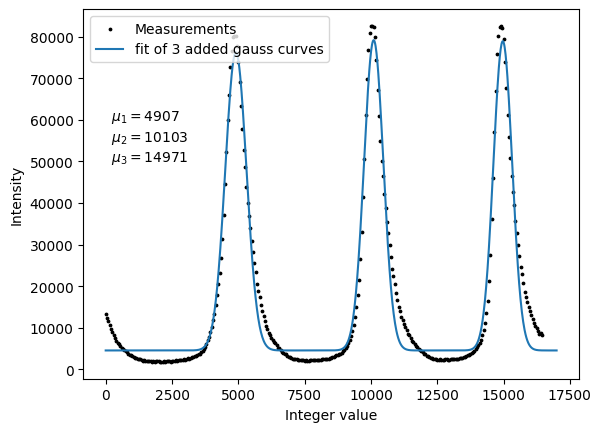

In [14]:
x_data = np.linspace(0,17000,1000)

plt.scatter(integer,intensity,s=3,c='black',label='Measurements')
plt.plot(x_data, fit_peaks(x_data,*popt2),label='fit of 3 added gauss curves')
plt.text(200,60000,r'$\mu_1 = 4907$')
plt.text(200,55000,r'$\mu_2 = 10103$')
plt.text(200,50000,r'$\mu_3 = 14971$')
plt.xlabel('Integer value')
plt.ylabel('Intensity')
plt.legend(loc="upper left")
plt.savefig('FSR.png')
plt.show()

In [15]:
pos = [popt2[1],popt2[4],popt2[7]]

In [16]:
pos

[np.float64(4907.6987224228515),
 np.float64(10103.612157063391),
 np.float64(14971.127384832054)]

In [17]:
popt3, pcov3 = curve_fit(lin_fit,[1,2,3],pos, p0=(1,1))
popt3

array([5031.71437476,  -69.28260859])

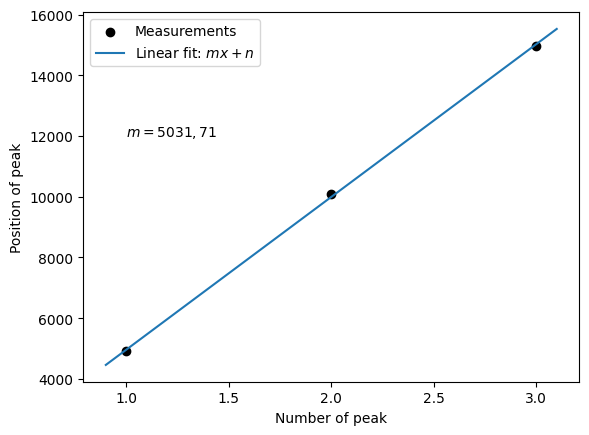

In [18]:
x1_data = np.linspace(0.9,3.1,1000)

plt.scatter([1,2,3],pos,c='black',label='Measurements')
plt.plot(x1_data,lin_fit(x1_data,*popt3),label='Linear fit: $mx+n$')
plt.xlabel('Number of peak')
plt.ylabel('Position of peak')
plt.text(1,12000,r'$m = 5031,71$')
plt.legend(loc="upper left")
plt.show()

The correction function: $\nu(x) = ax^2+bx$

In [19]:
b = FSR*(1-(pos[2]**2-pos[1]**2)/(pos[1]**2-pos[0]**2))/((pos[2]-pos[1])-(pos[1]-pos[0])*(pos[2]**2-pos[1]**2)/(pos[1]**2-pos[0]**2))
a = (FSR-b*(pos[1]-pos[0]))/(pos[1]**2-pos[0]**2)
b

np.float64(11901628.246953456)

In [20]:
pos

[np.float64(4907.6987224228515),
 np.float64(10103.612157063391),
 np.float64(14971.127384832054)]

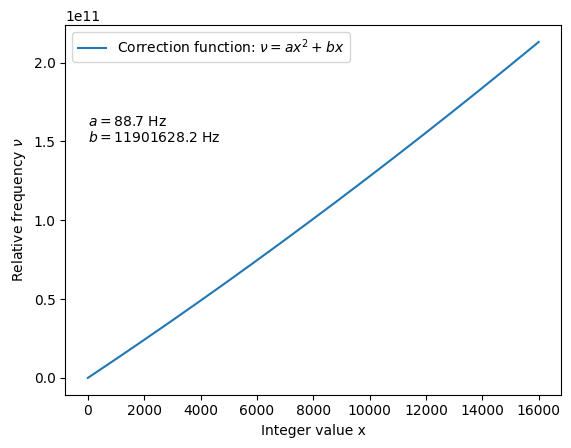

In [21]:
x1_data = np.linspace(0,16000,1000)

plt.plot(x1_data,x1_data**2*a+x1_data*b,label=r'Correction function: $\nu = ax^2+bx$')
plt.xlabel('Integer value x')
plt.ylabel(r'Relative frequency $\nu$')
plt.legend(loc="upper left")
plt.text(1,1.6e11,r'$a = 88.7$ Hz')
plt.text(1,1.5e11,r'$b = 11901628.2$ Hz')
plt.savefig('correction.png')
plt.show()

In [22]:
integer_neu = integer**2*a+integer*b

In [23]:
popt4, pcov4 = curve_fit(fit_peaks,integer_neu,intensity, p0=(80000,0.7e11,10000000000,80000,1.3e11,10000000000,80000,2e11,10000000000,200))
popt4

array([7.16799974e+04, 6.05648791e+10, 7.22248748e+09, 7.45959199e+04,
       1.29320816e+11, 7.05265419e+09, 7.43524697e+04, 1.98079240e+11,
       7.25135813e+09, 4.56885189e+03])

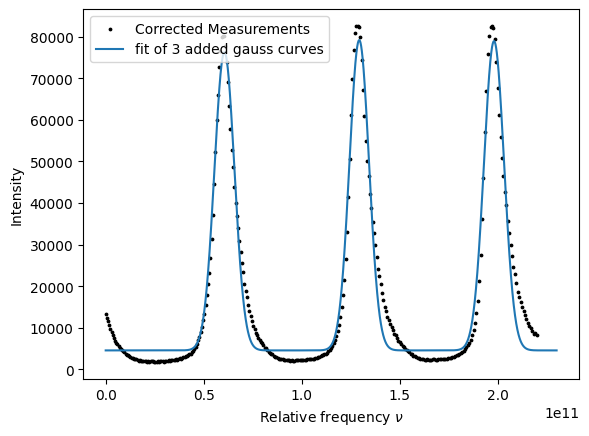

In [24]:
nu_data = np.linspace(0,2.3e11,10000)

plt.scatter(integer_neu,intensity,s=3,c='black',label='Corrected Measurements')
plt.plot(nu_data, fit_peaks(nu_data,*popt4),label='fit of 3 added gauss curves')
#plt.plot(nu_data,gauss(nu_data,80000,1.3e11,10000000000))
plt.xlabel(r'Relative frequency $\nu$')
plt.ylabel('Intensity')
plt.legend(loc="upper left")
plt.show()

In [25]:
def umr(x):
    return a*x**2+b*x

In [26]:
(popt4[4]-popt4[1])/(popt4[7]-popt4[4])

np.float64(0.9999638439748464)

In [27]:
(popt2[4]-popt2[1])/(popt2[7]-popt2[4])

np.float64(1.0674673198757345)

# $D_1$-Line

In [28]:
def gauss_D1(x,a,b,c,d,e,f,g,h,i,j,k,l,m):
    return a*np.exp(-((x-b)/c)**2)+d*np.exp(-((x-e)/f)**2)+g*np.exp(-((x-h)/i)**2)+j*np.exp(-((x-k)/l)**2)+m

## $I = 9A$

In [29]:
D1_9A = pd.read_table('../Messdaten/D1_9A/FPI_scan_data.dat').values

In [30]:
D1_9A_integer = D1_9A[:,0]
D1_9A_intensity = D1_9A[:,1]

In [31]:
poptD19, pcovD19 = curve_fit(gauss_D1,umr(D1_9A_integer),D1_9A_intensity, p0=(30000,4.1e10,5000000000,30000,5e10,5000000000,30000,6.7e10,5000000000,30000,7.8e10,5000000000,10000))
poptD19

array([3.03384388e+04, 4.24459085e+10, 4.12421547e+09, 3.08054659e+04,
       5.11467230e+10, 4.47921078e+09, 3.17507614e+04, 6.85351341e+10,
       4.23576191e+09, 2.83319705e+04, 7.73188430e+10, 3.72359009e+09,
       1.05375928e+04])

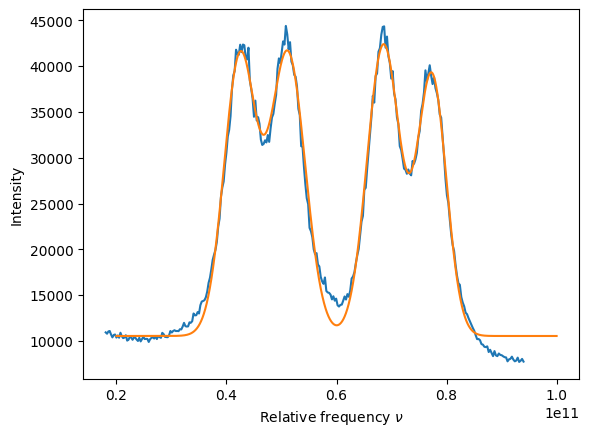

In [32]:
nu_data = np.linspace(0.2e11,1e11,10000)

plt.plot(umr(D1_9A_integer),D1_9A_intensity)
plt.xlabel(r'Relative frequency $\nu$')
plt.plot(nu_data,gauss_D1(nu_data,*poptD19))
plt.ylabel('Intensity')
plt.show()

## $I = 10A$

In [33]:
D1_10A = pd.read_table('../Messdaten/D1_10A/FPI_scan_data.dat').values

In [34]:
D1_10A_integer = D1_10A[:,0]
D1_10A_intensity = D1_10A[:,1]

In [35]:
poptD110, pcovD110 = curve_fit(gauss_D1,umr(D1_10A_integer),D1_10A_intensity, p0=(33000,6.34e10,4850000000,39000,7.35e10,4700000000,38000,9.2e10,4800000000,36000,1.02e11,4800000000,12000))
poptD110

array([2.68187235e+04, 6.31528471e+10, 3.67155380e+09, 2.99417217e+04,
       7.26545461e+10, 5.04756450e+09, 3.10062691e+04, 9.21982058e+10,
       3.99119160e+09, 2.98791302e+04, 1.01665744e+11, 4.60107199e+09,
       1.84624194e+04])

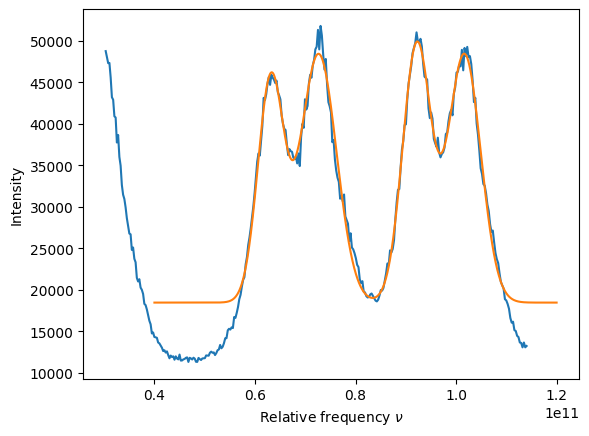

In [36]:
nu_data = np.linspace(0.4e11,1.2e11,10000)
plt.plot(umr(D1_10A_integer),D1_10A_intensity)
plt.plot(nu_data,gauss_D1(nu_data,*poptD110))
plt.xlabel(r'Relative frequency $\nu$')
plt.ylabel('Intensity')
plt.show()

## $I = 11A$

In [37]:
D1_11A = pd.read_table('../Messdaten/D1_11A1/FPI_scan_data.dat').values

In [38]:
D1_11A_integer = D1_11A[:,0]
D1_11A_intensity = D1_11A[:,1]

In [39]:
poptD111, pcovD111 = curve_fit(gauss_D1,umr(D1_11A_integer),D1_11A_intensity, p0=(48000,2.27e10,4500000000,54000,3.4e10,6200000000,58000,5.54e10,5800000000,53000,6.67e10,4500000000,17000))
poptD111

array([4.24275413e+04, 2.22098122e+10, 4.74868941e+09, 4.71445253e+04,
       3.39536821e+10, 6.32622431e+09, 5.24019351e+04, 5.55080059e+10,
       4.94139964e+09, 5.07853570e+04, 6.66156384e+10, 4.62112360e+09,
       2.13985992e+04])

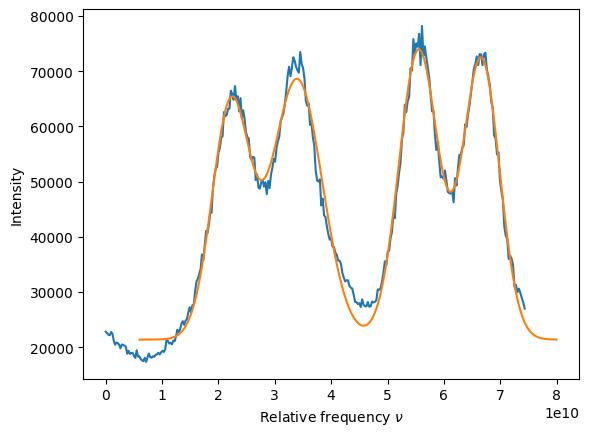

In [40]:
nu_data = np.linspace(0.06e11,0.8e11,10000)
plt.plot(umr(D1_11A_integer),D1_11A_intensity)
plt.plot(nu_data, gauss_D1(nu_data,*poptD111))
plt.xlabel(r'Relative frequency $\nu$')
plt.ylabel('Intensity')
plt.show()

## $I = 12A$

In [41]:
D1_12A = pd.read_table('../Messdaten/D1_12A/FPI_scan_data.dat').values

In [42]:
D1_12A_integer = D1_12A[:,0]
D1_12A_intensity = D1_12A[:,1]

In [43]:
poptD112, pcovD112 = curve_fit(gauss_D1,umr(D1_12A_integer),D1_12A_intensity, p0=(50000,3.56e10,4700000000,56000,4.74e10,5100000000,58000,7.03e10,4800000000,58000,8.2e10,4800000000,23000))
poptD112

array([4.74125941e+04, 3.57292330e+10, 4.59456550e+09, 5.29852512e+04,
       4.72095033e+10, 4.46791810e+09, 5.43975751e+04, 7.02694696e+10,
       4.67906993e+09, 5.73702372e+04, 8.17975663e+10, 4.30850459e+09,
       2.62961946e+04])

In [44]:
D1_12_pos = [poptD112[1],poptD112[4],poptD112[7],poptD112[10]]
D1_12_pos

[np.float64(35729232963.8584),
 np.float64(47209503278.98683),
 np.float64(70269469596.84209),
 np.float64(81797566326.44363)]

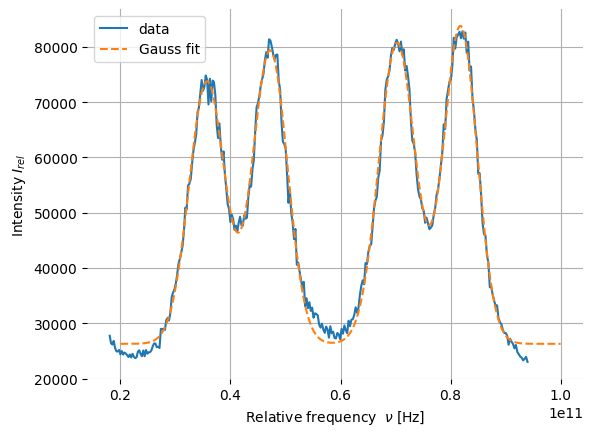

In [45]:
nu_data = np.linspace(0.2e11,1e11,10000)
plt.plot(umr(D1_12A_integer),D1_12A_intensity, label = 'data')
plt.plot(nu_data, gauss_D1(nu_data,*poptD112), linestyle = '--', label = 'Gauss fit')
plt.xlabel(r'Relative frequency $\;\nu$ [Hz]')
plt.ylabel('Intensity $I_{rel}$')
plt.legend(loc='upper left')
plt.grid()
plt.box(False)
#plt.savefig('Spec_D1_12A.png')
plt.show()

/tmp/ipykernel_43383/1367693797.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, Z, shading='auto', cmap=cm)


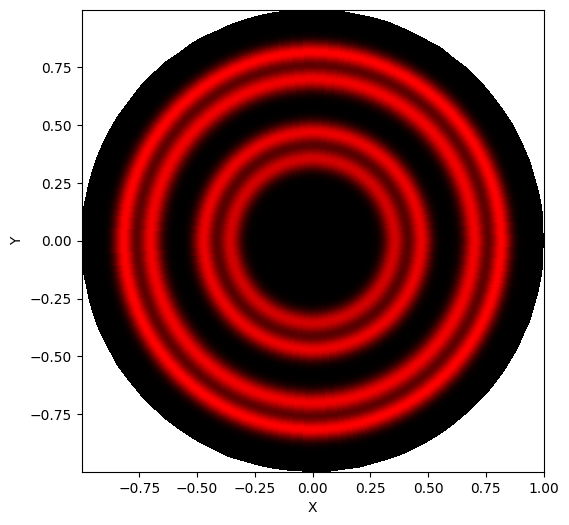

In [46]:
r = np.linspace(0,1,10000)
theta = np.linspace(0, 2 * np.pi, 100)  # angle from 0 to 2*pi

# Create the meshgrid for polar coordinates
R, Theta = np.meshgrid(r, theta)

# Convert polar to Cartesian coordinates
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

# Evaluate the radial function on the grid
Z = gauss_D1((R*(1e11)),*poptD112)

# Plot the color map
plt.figure(figsize=(6, 6))
plt.pcolormesh(X, Y, Z, shading='auto', cmap=cm)
#plt.colorbar(label='Function Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
#plt.box(None)
plt.axis('scaled')
#plt.savefig('Lines_D1_12A.png')
plt.show()

# $D_2$-Line

In [47]:
def gauss_D2(x,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s):
    return a*np.exp(-((x-b)/c)**2)+d*np.exp(-((x-e)/f)**2)+g*np.exp(-((x-h)/i)**2)+j*np.exp(-((x-k)/l)**2)+m*np.exp(-((x-n)/o)**2)+p*np.exp(-((x-q)/r)**2)+s

## $I = 9A$

In [48]:
D2_9A = pd.read_table('../Messdaten/D2_9A/FPI_scan_data.dat').values
D2_9A_integer = D2_9A[:,0]
D2_9A_intensity = D2_9A[:,1]

In [49]:
poptD29, pcovD29 = curve_fit(gauss_D2,umr(D2_9A_integer),D2_9A_intensity, p0=(16000,4.1e10,3000000000,30000,5e10,5000000000,20000,5.8e10,3000000000,30000,6.7e10,5000000000,24000,7.5e10,3000000000,18000,8.3e10,4000000000,10000))
poptD29

array([1.81534789e+04, 4.14119587e+10, 4.08356025e+09, 2.81959704e+04,
       4.99047567e+10, 3.94776577e+09, 2.57939575e+04, 5.79217447e+10,
       4.09517255e+09, 2.81603611e+04, 6.70639277e+10, 4.01288982e+09,
       2.78540242e+04, 7.51431907e+10, 4.02772353e+09, 1.64893428e+04,
       8.35923975e+10, 3.34326320e+09, 8.66027183e+03])

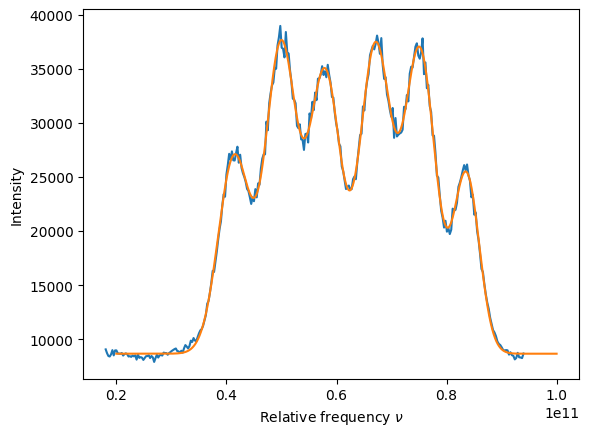

In [50]:
nu_data = np.linspace(0.2e11,1e11,10000)

plt.plot(umr(D2_9A_integer),D2_9A_intensity)
plt.xlabel(r'Relative frequency $\nu$')
plt.plot(nu_data,gauss_D2(nu_data,*poptD29))
plt.ylabel('Intensity')
plt.show()

## $I = 10A$

In [51]:
D2_10A = pd.read_table('../Messdaten/D2_10A1/FPI_scan_data.dat').values
D2_10A_integer = D2_10A[:,0]
D2_10A_intensity = D2_10A[:,1]

In [52]:
poptD210, pcovD210 = curve_fit(gauss_D2,umr(D2_10A_integer),D2_10A_intensity, p0=(35000,5.25e10,4000000000,55000,6.2e10,4500000000,58000,7.13e10,4800000000,58000,8.15e10,4200000000,60000,9e10,4400000000,40000,0.995e11,4000000000,16000))
poptD210

array([3.35138018e+04, 5.24429085e+10, 4.06598042e+09, 5.43608542e+04,
       6.24514294e+10, 4.99079201e+09, 5.40111811e+04, 7.16875457e+10,
       4.24733220e+09, 5.75866001e+04, 8.15739342e+10, 4.67566832e+09,
       5.69859039e+04, 9.04451911e+10, 4.16354190e+09, 3.71108031e+04,
       9.96306230e+10, 4.14175203e+09, 1.77192934e+04])

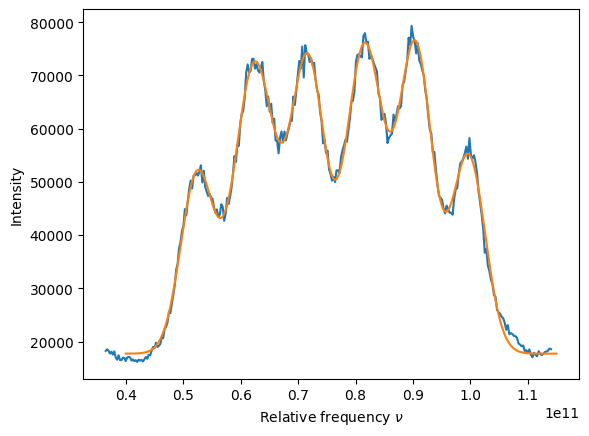

In [53]:
nu_data = np.linspace(0.4e11,1.15e11,10000)
plt.plot(umr(D2_10A_integer),D2_10A_intensity)
plt.plot(nu_data, gauss_D2(nu_data,*poptD210))
plt.xlabel(r'Relative frequency $\nu$')
plt.ylabel('Intensity')
plt.show()

## $I = 11A$

In [54]:
D2_11A = pd.read_table('../Messdaten/D2_11A/FPI_scan_data.dat').values
D2_11A_integer = D2_11A[:,0]
D2_11A_intensity = D2_11A[:,1]

In [55]:
poptD211, pcovD211 = curve_fit(gauss_D2,umr(D2_11A_integer),D2_11A_intensity, p0=(36000,2.5e10,4700000000,55000,3.58e10,4900000000,52000,4.57e10,4400000000,58000,5.73e10,4800000000,60000,6.75e10,4800000000,40000,7.8e10,4000000000,20000))
poptD211

array([3.34745849e+04, 2.52101213e+10, 4.15712240e+09, 5.08032402e+04,
       3.59008024e+10, 5.08400175e+09, 4.80104588e+04, 4.59022614e+10,
       4.44514403e+09, 5.45951809e+04, 5.73377413e+10, 4.92283136e+09,
       5.28166136e+04, 6.73457024e+10, 4.90507562e+09, 3.43944646e+04,
       7.80725780e+10, 3.84090405e+09, 2.31191166e+04])

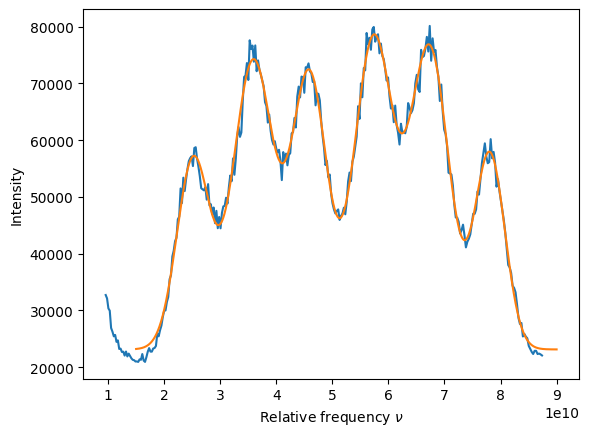

In [56]:
nu_data = np.linspace(0.15e11,0.9e11,10000)
plt.plot(umr(D2_11A_integer),D2_11A_intensity)
plt.plot(nu_data,gauss_D2(nu_data,*poptD211))
plt.xlabel(r'Relative frequency $\nu$')
plt.ylabel('Intensity')
plt.show()

## $I = 12A$

In [57]:
D2_12A = pd.read_table('../Messdaten/D2_12A/FPI_scan_data.dat').values
D2_12A_integer = D2_12A[:,0]
D2_12A_intensity = D2_12A[:,1]

In [58]:
poptD212, pcovD212 = curve_fit(gauss_D2,umr(D2_12A_integer),D2_12A_intensity, p0=(34000,2.75e10,4500000000,48000,3.95e10,5300000000,47000,5.04e10,4600000000,50000,6.27e10,4900000000,50000,7.4e10,4800000000,35000,8.55e10,4000000000,25000))
poptD212

array([2.20587744e+04, 2.78708424e+10, 3.06971782e+09, 3.42041462e+04,
       3.94875985e+10, 4.92362530e+09, 3.30178231e+04, 5.04794941e+10,
       4.11971104e+09, 3.79462164e+04, 6.29502388e+10, 4.27503411e+09,
       3.69586217e+04, 7.38147825e+10, 4.21039153e+09, 2.46207510e+04,
       8.53009099e+10, 2.68235595e+09, 3.55019989e+04])

In [59]:
D2_12_pos = [poptD212[1],poptD212[4],poptD212[7],poptD212[10],poptD212[13],poptD212[16]]
D2_12_pos

[np.float64(27870842394.289856),
 np.float64(39487598493.569336),
 np.float64(50479494120.79867),
 np.float64(62950238819.23654),
 np.float64(73814782501.66537),
 np.float64(85300909942.7551)]

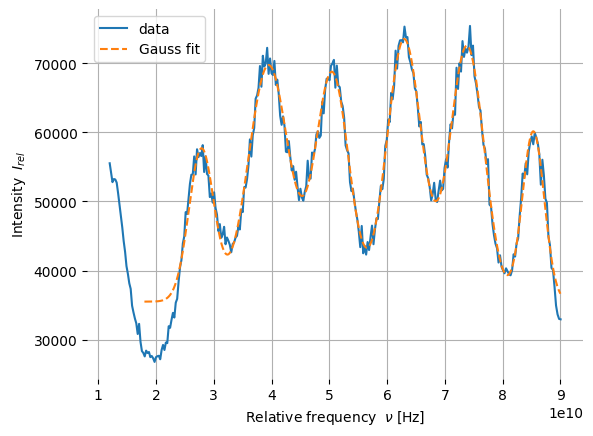

In [60]:
nu_data = np.linspace(0.18e11,0.9e11,10000)
plt.plot(umr(D2_12A_integer),D2_12A_intensity, label = 'data')
plt.plot(nu_data, gauss_D2(nu_data,*poptD212), linestyle = '--', label = 'Gauss fit')
plt.xlabel(r"Relative frequency $\;\nu$ [Hz]")
plt.ylabel(r"Intensity $\;I_{rel}$")
plt.grid()
plt.box(False)
plt.legend(loc='upper left')
#plt.savefig('Spec_D2_12A.png')
plt.show()

/tmp/ipykernel_43383/3114747892.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, Z, shading='auto', cmap=cm)


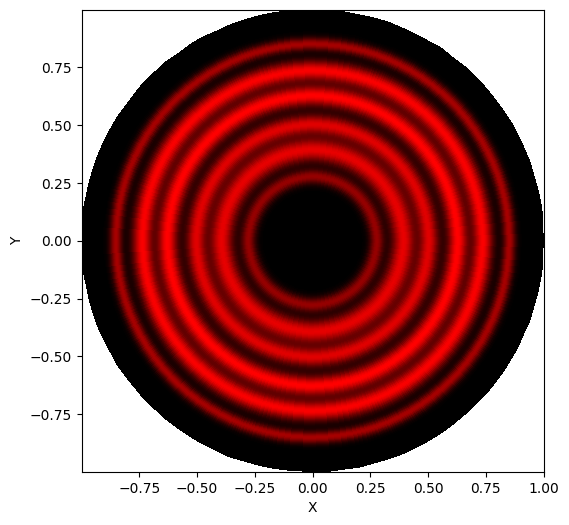

In [61]:
r = np.linspace(0,1,10000)
theta = np.linspace(0, 2 * np.pi, 100)  # angle from 0 to 2*pi

# Create the meshgrid for polar coordinates
R, Theta = np.meshgrid(r, theta)

# Convert polar to Cartesian coordinates
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

# Evaluate the radial function on the grid
Z = gauss_D2((R*(1e11)),*poptD212)

# Plot the color map
plt.figure(figsize=(6, 6))
plt.pcolormesh(X, Y, Z, shading='auto', cmap=cm)
#plt.colorbar(label='Function Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
#plt.box(None)
plt.axis('scaled')
#plt.savefig('Lines_D2_12A.png')
plt.show()

# Bestimmung der Landé-Faktoren

In [62]:
B = popt1[0]*12
B

np.float64(1.081356628917516)

In [63]:
gS12_D1 = cs.h/(2*mu_B*B)*(D1_12_pos[3]-D1_12_pos[0]+D1_12_pos[2]-D1_12_pos[1])
gS12_D2_1 = cs.h/(2*mu_B*B)*(D2_12_pos[5]-D2_12_pos[0]+D2_12_pos[3]-D2_12_pos[2])
gS12_D2_2 = cs.h/(4*mu_B*B)*(3*(D2_12_pos[5]-D2_12_pos[0])+D2_12_pos[1]-D2_12_pos[4])
gS12_D2_3 = cs.h/(2*mu_B*B)*(3*(D2_12_pos[3]-D2_12_pos[2])-D2_12_pos[1]+D2_12_pos[4])

In [64]:
gS12 = (gS12_D1+gS12_D2_1+gS12_D2_2+gS12_D2_3)/4
gS12

np.float64(2.3104665657251333)

In [65]:
gP12 = cs.h/(2*mu_B*B)*(D1_12_pos[3]-D1_12_pos[0]-D1_12_pos[2]+D1_12_pos[1])
gP12

np.float64(0.7601080294739059)

In [66]:
gP32_1 = cs.h/(2*mu_B*B)*(D2_12_pos[5]-D2_12_pos[0]-D2_12_pos[3]+D2_12_pos[2])
gP32_2 = cs.h/(4*mu_B*B)*(D2_12_pos[5]-D2_12_pos[0]+D2_12_pos[4]-D2_12_pos[1])
gP32_3 = cs.h/(2*mu_B*B)*(D2_12_pos[3]-D2_12_pos[2]-D2_12_pos[1]+D2_12_pos[4])

In [67]:
gP32 = (gP32_1+gP32_2+gP32_3)/3
gP32_2

np.float64(1.5156534910758548)

In [83]:
gS_12 = []

I = 9

for i in [poptD19,poptD110,poptD111,poptD112]:
    B = popt1[0]*I
    gS_12.append(cs.h/(2*mu_B*B)*(i[10]-i[1]+i[7]-i[4]))
    I = I+1

I = 9
for i in [poptD29,poptD210,poptD211,poptD212]:
    B = popt1[0]*I
    gS_12.append(cs.h/(2*mu_B*B)*(i[16]-i[1]+i[10]-i[7]))
    gS_12.append(cs.h/(4*mu_B*B)*(3*(i[16]-i[1])+i[4]-i[13]))
    gS_12.append(cs.h/(2*mu_B*B)*(3*(i[10]-i[7])-i[4]+i[13]))
    I = I+1

In [84]:
np.average(gS_12)

np.float64(2.300716578997796)

In [70]:
gP_12 = []
I = 9

for i in [poptD19,poptD110,poptD111,poptD112]:
    B = popt1[0]*I
    gP_12.append(cs.h/(2*mu_B*B)*(i[10]-i[1]-i[7]+i[4]))
    I = I+1

In [71]:
np.average(gP_12)

np.float64(0.7764575684454478)

In [93]:
gP_32 = []
I = 9

for i in [poptD29,poptD210,poptD211,poptD212]:
    gP_32.append(cs.h/(2*mu_B*B)*(i[16]-i[1]-i[10]+i[7]))
    gP_32.append(cs.h/(4*mu_B*B)*(i[16]-i[1]+i[13]-i[4]))
    gP_32.append(cs.h/(2*mu_B*B)*(i[10]-i[7]-i[4]+i[13]))

In [94]:
gP_32

[np.float64(1.0914570127688201),
 np.float64(1.1136302386361208),
 np.float64(1.1358034645034216),
 np.float64(1.2322924687551247),
 np.float64(1.2418535308741045),
 np.float64(1.2514145929930842),
 np.float64(1.368588112247619),
 np.float64(1.3925955408181903),
 np.float64(1.4166029693887614),
 np.float64(1.4852832550688522),
 np.float64(1.5156534910758548),
 np.float64(1.5460237270828572)]

In [101]:
np.average([2.296,3.316])

np.float64(2.806)

In [112]:
1.316/(4/3)-1

-0.0129999999999999

In [106]:
2/2.5-1

-0.19999999999999996